# Test MonoDecoders: Sequence and Geometry
This notebook replicates the training logic from `learn.py` using the decoder in `mono_decoders.py` for amino acid and geometry prediction.

In [1]:
#use autoreload
%load_ext autoreload
%autoreload 2

In [2]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [3]:
# Imports
import torch
from torch_geometric.data import DataLoader
import numpy as np
from foldtree2.src import pdbgraph
from foldtree2.src import foldtree2_ecddcd as ft2
from foldtree2.src.mono_decoders import MultiMonoDecoder
import os
import tqdm
import random
import torch.nn.functional as F

In [4]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data setup
datadir = '../../datasets/foldtree2/'
dataset_path = 'structs_traininffttest.h5'
converter = pdbgraph.PDB2PyG(aapropcsv='./foldtree2/config/aaindex1.csv')
struct_dat = pdbgraph.StructureDataset(dataset_path)
train_loader = DataLoader(struct_dat, batch_size=5, shuffle=True, num_workers=4)

data_sample = next(iter(train_loader))

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Model setup

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]
ndim_fft2i = data_sample['fourier2di'].x.shape[1]
ndim_fft2r = data_sample['fourier2dr'].x.shape[1]
print(data_sample)

HeteroDataBatch(
  identifier=[5],
  AA={
    x=[1323, 20],
    batch=[1323],
    ptr=[6],
  },
  R_true={
    x=[1323, 3, 3],
    batch=[1323],
    ptr=[6],
  },
  bondangles={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  coords={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  fourier1di={
    x=[1323, 80],
    batch=[1323],
    ptr=[6],
  },
  fourier1dr={
    x=[1323, 80],
    batch=[1323],
    ptr=[6],
  },
  fourier2di={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  fourier2dr={
    x=[5, 1300],
    batch=[5],
    ptr=[6],
  },
  godnode={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  godnode4decoder={
    x=[5, 5],
    batch=[5],
    ptr=[6],
  },
  plddt={
    x=[1323, 1],
    batch=[1323],
    ptr=[6],
  },
  positions={
    x=[1323, 256],
    batch=[1323],
    ptr=[6],
  },
  res={
    x=[1323, 857],
    batch=[1323],
    ptr=[6],
  },
  t_true={
    x=[1323, 3],
    batch=[1323],
    ptr=[6],
  },
  (godnode4decoder, informs, res)={ edge_index=[2, 1

In [6]:

num_embeddings = 40
embedding_dim = 128
hidden_size = 300

encoder = ft2.mk1_Encoder(
	in_channels=ndim,
	hidden_channels=[hidden_size, hidden_size],
	out_channels=embedding_dim,
	metadata={'edge_types': [('res','contactPoints','res') ]},
	num_embeddings=num_embeddings,
	commitment_cost=0.9,
	edge_dim=1,
	encoder_hidden=hidden_size,
	EMA=True,
	nheads=5,
	dropout_p=0.01,
	reset_codes=False,
	flavor='transformer',
	fftin=True
)


print(encoder)
encoder = encoder.to(device)




Seed set to 42


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(300, 300, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(300)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=600, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=600, out_features=300, bias=True)
    (3): GELU(approximate='none')
  )
  (lin): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): GELU(approximate='none')
  )
  (out_dense): Sequential(
    (0): Linear(in_features=320, out_features=300, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): GELU(approximate='none'

In [7]:
use_monodecoder = True  # Set to True to use MultiMonoDecoder, False for Single Decoder
if use_monodecoder == True:
	# MultiMonoDecoder for sequence and geometry
	mono_configs = {
		'sequence_transformer': {
			'in_channels': {'res': embedding_dim},
			'xdim': 20,
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size*2] , ('res','backbonerev','res'): [hidden_size*2]},
			'layers': 1,
			'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size//2],
			'amino_mapper': converter.aaindex,
			'flavor': 'sage',
			'nheads': 8,
			'dropout': 0.005,
			'normalize': False,
			'residual': False
		},
		
		'contacts': {
			'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size]*8, ('res','backbonerev','res'): [hidden_size]*8, ('res','informs','godnode4decoder'): [hidden_size]*8 , ('godnode4decoder','informs','res'): [hidden_size]*8 },
			'layers': 4,
			'FFT2decoder_hidden': [hidden_size, hidden_size, hidden_size],
			'contactdecoder_hidden': [hidden_size//4, hidden_size//8],
			'anglesdecoder_hidden': [hidden_size//2, hidden_size//2],
			'nheads': 1,
			'Xdecoder_hidden': [hidden_size, hidden_size,  hidden_size ],
			'metadata': converter.metadata,
			'flavor': 'sage',
			'dropout': 0.005,
			'output_fft': False,
			'output_rt':False,
			'output_angles': False,
			'normalize': True,
			'residual': False,
			'contact_mlp': False,
			'ncat': 8,
			'output_edge_logits': True
		},
	}

	
	'''
	
		'geometry_transformer': {
			'in_channels':  embedding_dim ,
			'dropout_p': 0.05,
			'decoder_hidden': 100,
			'out_angles': True,
			'out_coords': True,
			'out_RT': False,
			'nheads': 8,
			'nlayers': 3
		}
	}
	'''
	decoder = MultiMonoDecoder( configs=mono_configs)
else:
	# Single decoder 
	decoder = ft2.HeteroGAE_Decoder(
			in_channels={'res': embedding_dim , 'godnode4decoder': ndim_godnode, 'foldx': 23},
			concat_positions=True,
			hidden_channels={('res','backbone','res'): [hidden_size]*5, ('res','backbonerev','res'): [hidden_size]*5, ('res','informs','godnode4decoder'): [hidden_size]*5 , ('godnode4decoder','informs','res'): [hidden_size]*5},
			layers=3,
			AAdecoder_hidden=[hidden_size, hidden_size, hidden_size//2],
			Xdecoder_hidden=[hidden_size, hidden_size, hidden_size],
			contactdecoder_hidden=[hidden_size//2, hidden_size//2],
			anglesdecoder_hidden=[hidden_size//2, hidden_size//4],
			nheads=5,
			amino_mapper=converter.aaindex,
			flavor='sage',
			dropout=0.005,
			normalize=True,
			residual=False,
			contact_mlp=False
		)
decoder = decoder.to(device)
print(decoder)

Seed set to 42
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Seed set to 42


Initializing decoder for task: sequence_transformer
False True False False False
600 8 1 0.005
Initializing decoder for task: contacts
False False True False False
MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): Dropout(p=0.005, inplace=False)
        (1): Linear(in_features=384, out_features=600, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=600, out_features=600, bias=True)
        (4): Tanh()
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
            )
            (linear1): Linear(in_features=600, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out

In [8]:
# Training loop (demo, similar to learn.py)
import time
from collections import defaultdict

num_epochs = 100  # For demonstration, keep small
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

edgeweight = 0.1
logitweight = 0.1
xweight = 0.1
fft2weight = 0.01
vqweight = 0.001
angles_weight = 0.001
clip_grad = True
encoder.device = device
encoder.train()
decoder.train()

MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): Dropout(p=0.005, inplace=False)
        (1): Linear(in_features=384, out_features=600, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=600, out_features=600, bias=True)
        (4): Tanh()
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
            )
            (linear1): Linear(in_features=600, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out_features=600, bias=True)
            (norm1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((600,), eps=1e-05, elementwise_a

In [9]:
#get one sample from the dataloader
train_loader = DataLoader(struct_dat, batch_size=1, shuffle=True, num_workers=4)
import random

randint = random.randint(0, len(train_loader) - 1)
print(f"Randomly selected batch index: {randint}")
data_sample = struct_dat[randint]
print(data_sample)
data = data_sample.to(device)
optimizer.zero_grad()
z, vqloss = encoder(data , debug = True)
print('Encoded z shape:', z.shape)

Randomly selected batch index: 912
HeteroData(
  identifier='A0A1I8D3W7',
  AA={ x=[624, 20] },
  R_true={ x=[624, 3, 3] },
  bondangles={ x=[624, 3] },
  coords={ x=[624, 3] },
  fourier1di={ x=[624, 80] },
  fourier1dr={ x=[624, 80] },
  fourier2di={ x=[1, 1300] },
  fourier2dr={ x=[1, 1300] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  plddt={ x=[624, 1] },
  positions={ x=[624, 256] },
  res={ x=[624, 857] },
  t_true={ x=[624, 3] },
  (godnode4decoder, informs, res)={ edge_index=[2, 624] },
  (godnode, informs, res)={ edge_index=[2, 624] },
  (res, backbone, res)={
    edge_index=[2, 1247],
    edge_attr=[623],
  },
  (res, backbonerev, res)={
    edge_index=[2, 1247],
    edge_attr=[623],
  },
  (res, contactPoints, res)={
    edge_index=[2, 4552],
    edge_attr=[4552],
  },
  (res, hbond, res)={
    edge_index=[2, 632],
    edge_attr=[632],
  },
  (res, informs, godnode)={ edge_index=[2, 624] },
  (res, informs, godnode4decoder)={ edge_index=[2, 624] },
  (res, wi

In [10]:
from Bio import PDB
from Bio.PDB import PDBParser
from foldtree2.src.AFDB_tools import grab_struct

def getCAatoms(pdb_file):
	parser = PDBParser(QUIET=True)
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	return ca_atoms

In [11]:
#get aa and contacts

from torch_geometric.data import DataLoader , HeteroData
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
#add precision and recall metrics
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	print(ords)
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	print( 'positional encoding shape:', positional_encoding.shape )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	print( data['res'].x.shape )
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	out = decoder( data , allpairs )
	recon_x = out['aa'] if 'aa' in out else None
	edge_probs = out['edge_probs'] if 'edge_probs' in out else None
	logits = out['edge_logits'] if 'edge_logits' in out else None

	print( edge_probs.shape)
	"""
	try:
		amino_map = decoder.decoders['sequence'].amino_acid_indices
	except:
		amino_map = decoder.decoders['sequence_transformer'].amino_acid_indices
		print('Using amino_acid_indices_dict instead of amino_acid_indices')
	revmap_aa = { v:k for k,v in amino_map.items() }
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	
	"""
	aastr = None

	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	logits = torch.sum( logits , dim=1).squeeze()
	logits = logits.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	return aastr ,edge_probs, logits , out

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import colour

def plot_logits_sequence_on_ax(selected_indices, num_embeddings, ax, max_width=64, line_spacing=1, show_title=True, show_colorbar=False):
	"""
	Plots a wrapped embedding sequence using argmax from logits on a given matplotlib Axes.
	
	Parameters:
		logits (np.ndarray): Array of shape (sequence_length, num_embeddings).
		num_embeddings (int): Number of possible embeddings.
		ax (matplotlib.axes.Axes): Target axis to draw the plot.
		max_width (int): Max tokens per line.
		line_spacing (int): White lines between sequences.
		show_title (bool): If True, show a title on the subplot.
		show_colorbar (bool): If True, attach a colorbar to the plot.
	"""
	################ Process inputs
	selected_indices = np.array(selected_indices)
	# Create color mapping
	ord_colors = colour.Color("red").range_to(colour.Color("blue"), num_embeddings)
	ord_colors = np.array([c.get_rgb() for c in ord_colors])
	sequence_colors = ord_colors[selected_indices]

	# Compute rows and canvas
	total_len = len(selected_indices)
	rows = int(np.ceil(total_len / max_width))
	height = rows * (1 + line_spacing) - line_spacing
	canvas = np.ones((height, max_width, 3))  # White background

	for i in range(rows):
		start = i * max_width
		end = min((i + 1) * max_width, total_len)
		row_colors = sequence_colors[start:end]
		row_y = i * (1 + line_spacing)
		canvas[row_y, :len(row_colors), :] = row_colors

	# Plot on given axis
	ax.imshow(canvas, aspect='auto')
	ax.axis('off')
	if show_title:
		ax.set_title("Embedding Selection (argmax)")

	# Optional colorbar
	if show_colorbar:
		from matplotlib.colors import ListedColormap
		cmap = ListedColormap(ord_colors)
		norm = plt.Normalize(vmin=0, vmax=num_embeddings - 1)
		sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
		sm.set_array([])
		plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.01)

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:45<00:00,  1.81s/it]


Epoch 0: AA Loss: 2.8728, Edge Loss: 1.0998, VQ Loss: 0.3798 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.5189
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 37, 10,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 10, 37,
        37, 37, 10, 10, 37, 10, 10, 10, 10, 10, 10, 10, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 10, 10, 10, 10, 10, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

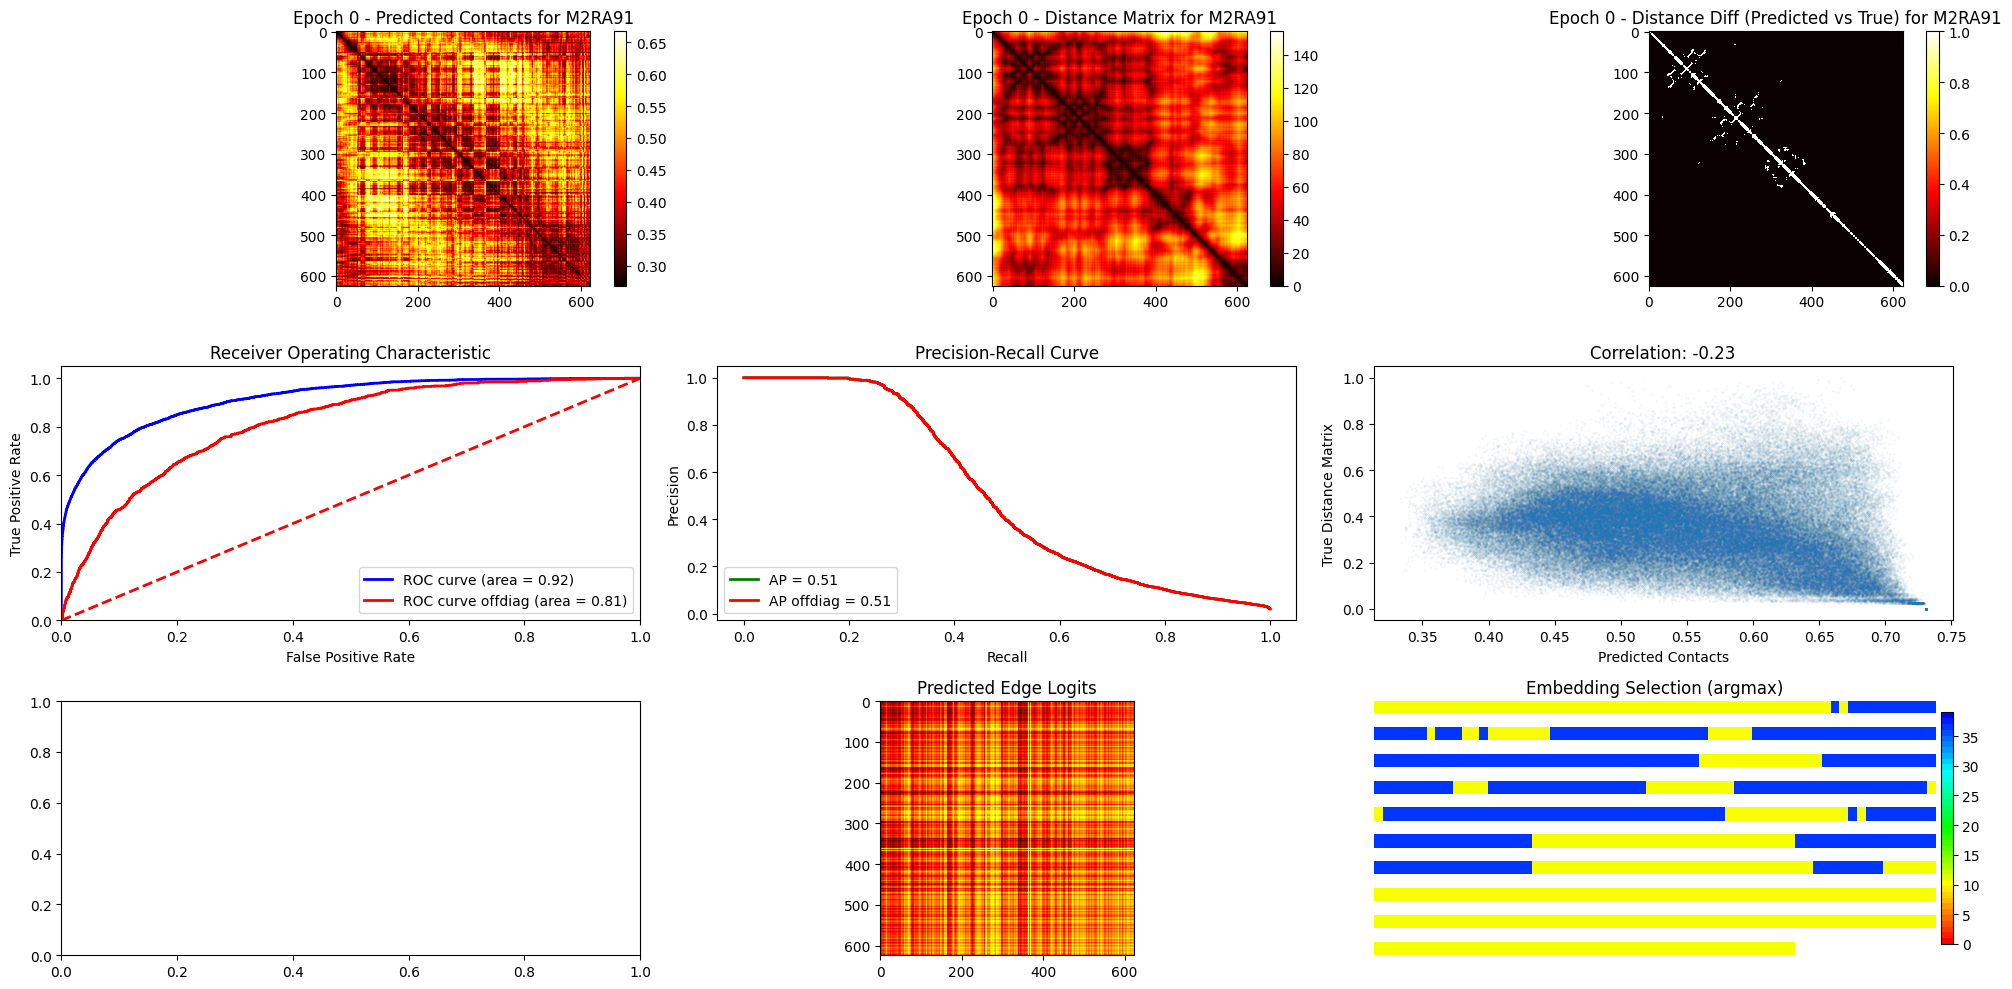

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:30<00:00,  2.16s/it]


Epoch 1: AA Loss: 2.5341, Edge Loss: 1.0654, VQ Loss: 0.4035 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.5013
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37, 10, 10, 10, 10, 10, 37, 10,  9, 10, 10, 37, 10, 10, 10, 10,
         2, 37, 37, 10, 10, 10, 37, 37, 10, 10, 10, 37, 10, 37, 37, 37, 37, 10,
         2, 37, 37, 10, 10, 37, 37, 10, 10,  9, 37, 10, 10,  9, 10, 10, 10, 10,
         2, 10, 37,  2, 37, 10, 10, 37,  9, 37, 10, 10, 10, 37, 37, 10, 10, 10,
        37, 37, 10, 10, 37, 37, 37, 10, 10, 10, 10, 37, 10, 37, 10, 37, 10, 10,
        10,  9, 10, 37,  9,  9, 37,  9, 10, 10, 37, 37, 10, 37,  2, 37, 37, 10,
         9, 10, 10, 37, 37, 10, 37, 37, 10, 37, 37, 10, 10, 37,  2, 37, 10, 10,
        37, 37, 37, 10, 37, 37, 10, 10, 10, 10, 37, 37,  2, 37, 37, 10, 10, 37,
        10, 10,  9, 37, 10,  9, 10, 10, 10, 10, 10, 10, 10, 37,  2, 37, 37, 10,
        10, 10, 37, 37, 10, 37, 10, 37, 10, 10, 10, 10, 10, 37, 37,  2, 1

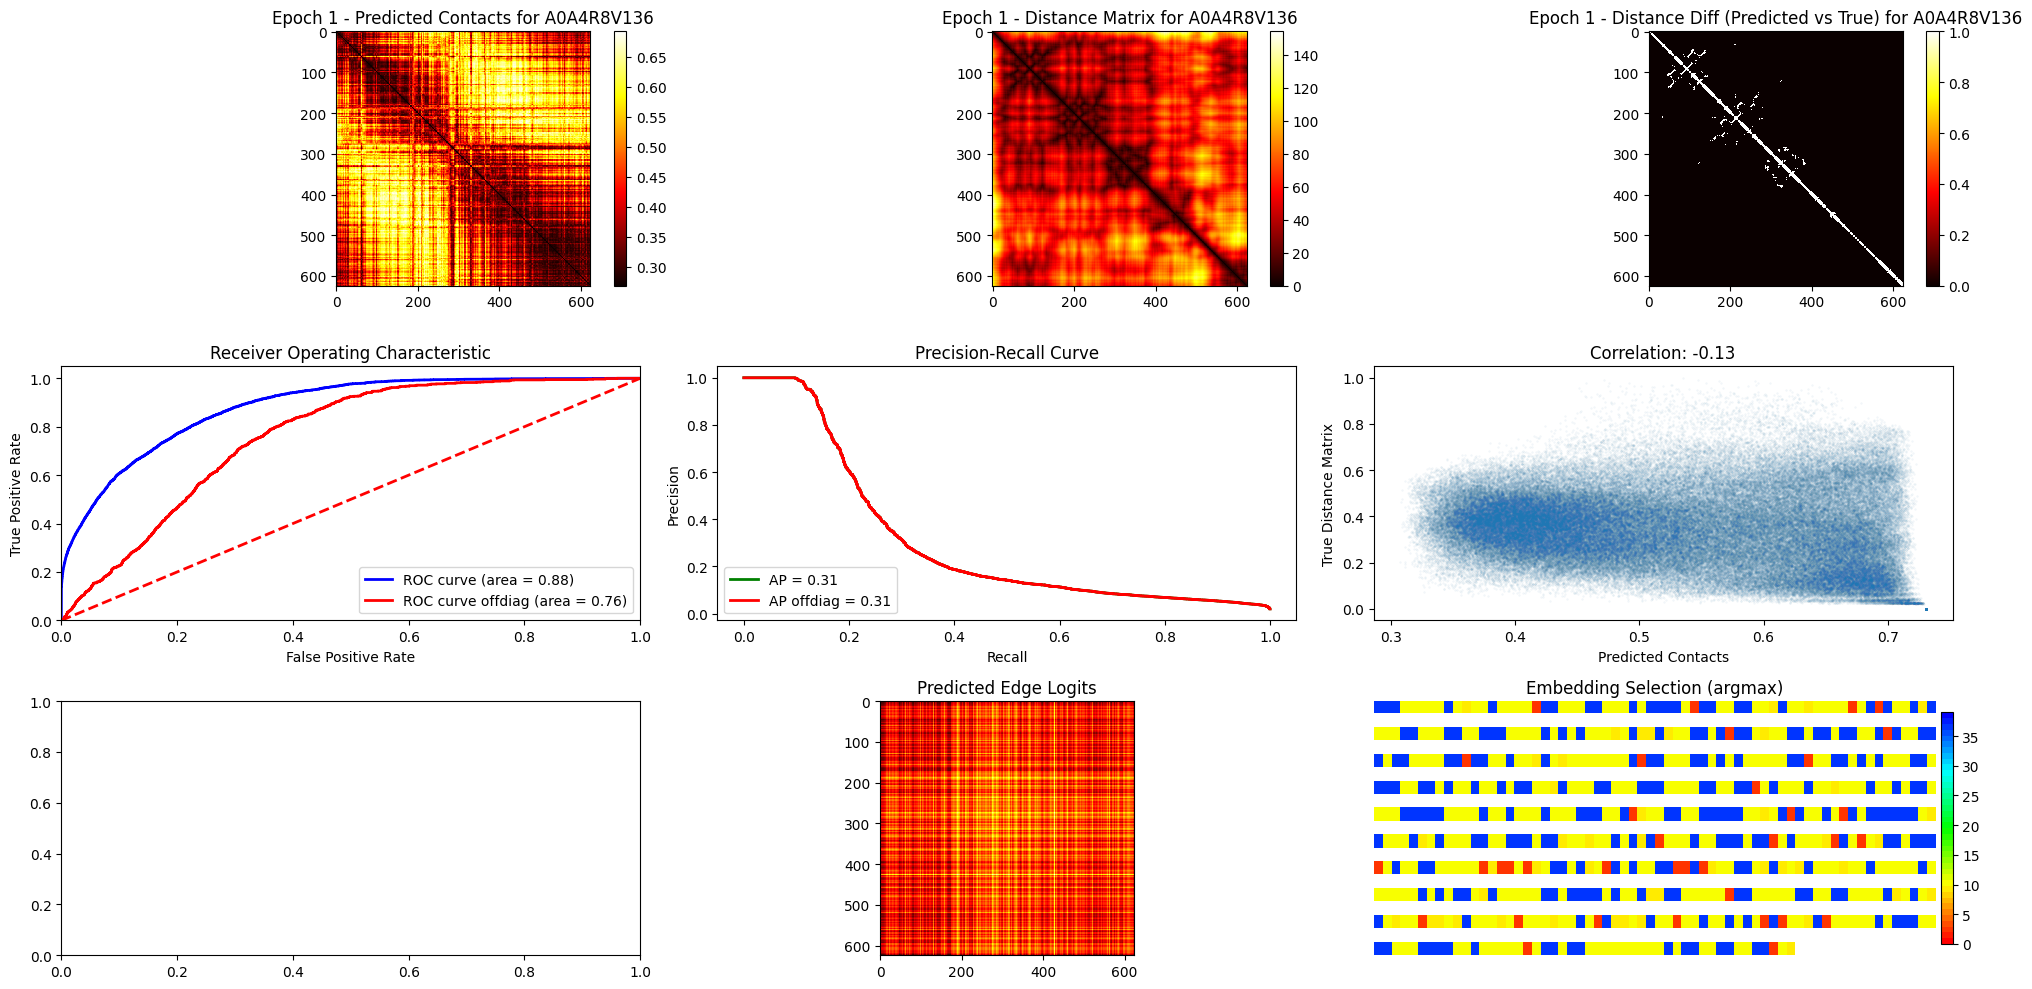

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:36<00:00,  2.22s/it]


Epoch 2: AA Loss: 1.8656, Edge Loss: 1.0543, VQ Loss: 0.3450 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.4984
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37, 10, 10, 10, 10, 10, 37, 10,  4, 10, 10, 37, 10, 10, 10, 10,
         2, 37, 37, 10, 10, 10, 37, 37, 10, 10, 10, 37, 10, 37, 37, 33, 37, 10,
        28, 37, 37, 10, 10, 37, 37, 10, 10,  9, 37,  9, 10,  9, 10, 10,  9, 10,
        22, 10, 37, 29, 37, 10, 10, 37,  3, 37, 10, 10, 10, 37, 37, 10, 10, 10,
        37, 37, 10, 10, 37, 37, 37, 10, 10, 10, 10, 37, 10, 37, 10, 37, 10, 10,
        10, 25, 10, 37,  9,  9, 37, 29, 10, 10,  2, 37, 10, 37,  9, 37, 37, 10,
         9, 10, 10,  2, 37, 10,  2, 37, 10, 37, 37, 10,  9, 37, 38, 37, 10, 10,
        37, 37, 37,  9, 37, 37, 10, 10, 10, 10, 37, 37, 22,  2, 37,  9, 10, 37,
        10, 10,  9, 37, 10,  9, 10, 10, 10, 10, 10, 10,  9, 37,  2, 37, 37, 29,
        10, 10, 37, 37, 10, 37, 10, 37,  9, 10, 10, 10, 10, 37, 37,  2, 1

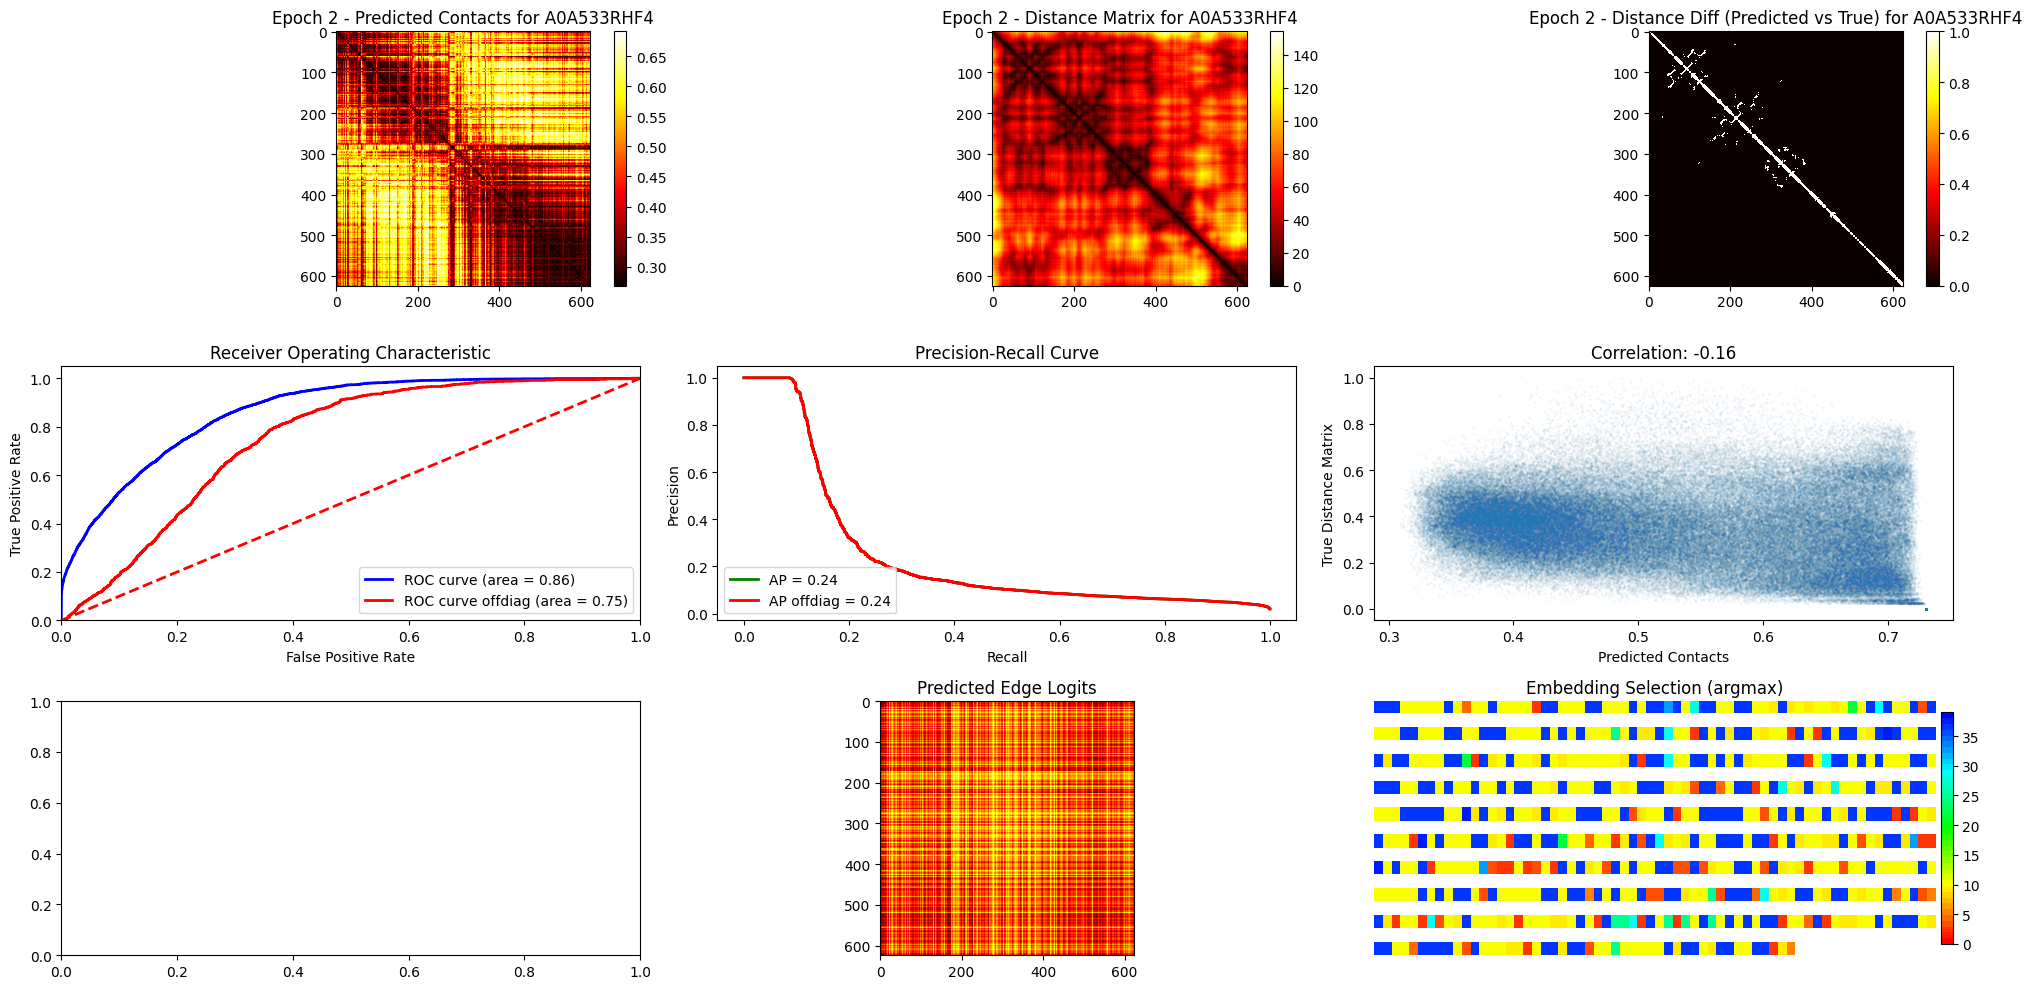

Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:40<00:00,  2.24s/it]


Epoch 3: AA Loss: 1.5218, Edge Loss: 1.0477, VQ Loss: 0.1981 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.4937
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37,  9,  9, 10,  9, 10, 37,  9,  4,  9, 10, 37, 10,  6,  9,  6,
         2, 37, 37,  6, 10, 20, 37, 37, 10, 10, 10, 37, 10, 37, 37, 30, 37, 10,
         5, 37, 37,  3, 10, 37, 37, 10, 10, 38, 37,  3, 10,  3, 10, 10,  3,  6,
        28, 10, 37, 28, 37,  9, 10, 37, 28, 37, 10, 10, 10, 37, 37, 10, 10, 10,
        37, 37, 10, 10, 37, 37, 37,  3, 10,  6, 10, 37, 10, 37,  3, 37, 10,  3,
        10,  5, 10, 37, 29, 22, 37, 28,  3, 10, 30, 37, 10, 37, 38, 37, 37, 10,
        38, 10,  9, 30, 37, 10, 30, 37, 10, 37, 37, 10, 38, 37, 28, 37, 10, 10,
        37, 37, 37,  3, 37, 37, 10, 10, 10,  6, 37, 37, 28, 33, 37,  3,  6,  2,
        10,  6, 38, 37, 10,  3,  9,  3, 10, 10,  6,  6, 20, 37, 30, 37, 37, 22,
         3, 10, 37, 37, 10, 37, 10, 37,  9, 10, 10, 10,  6, 37, 37, 30,  

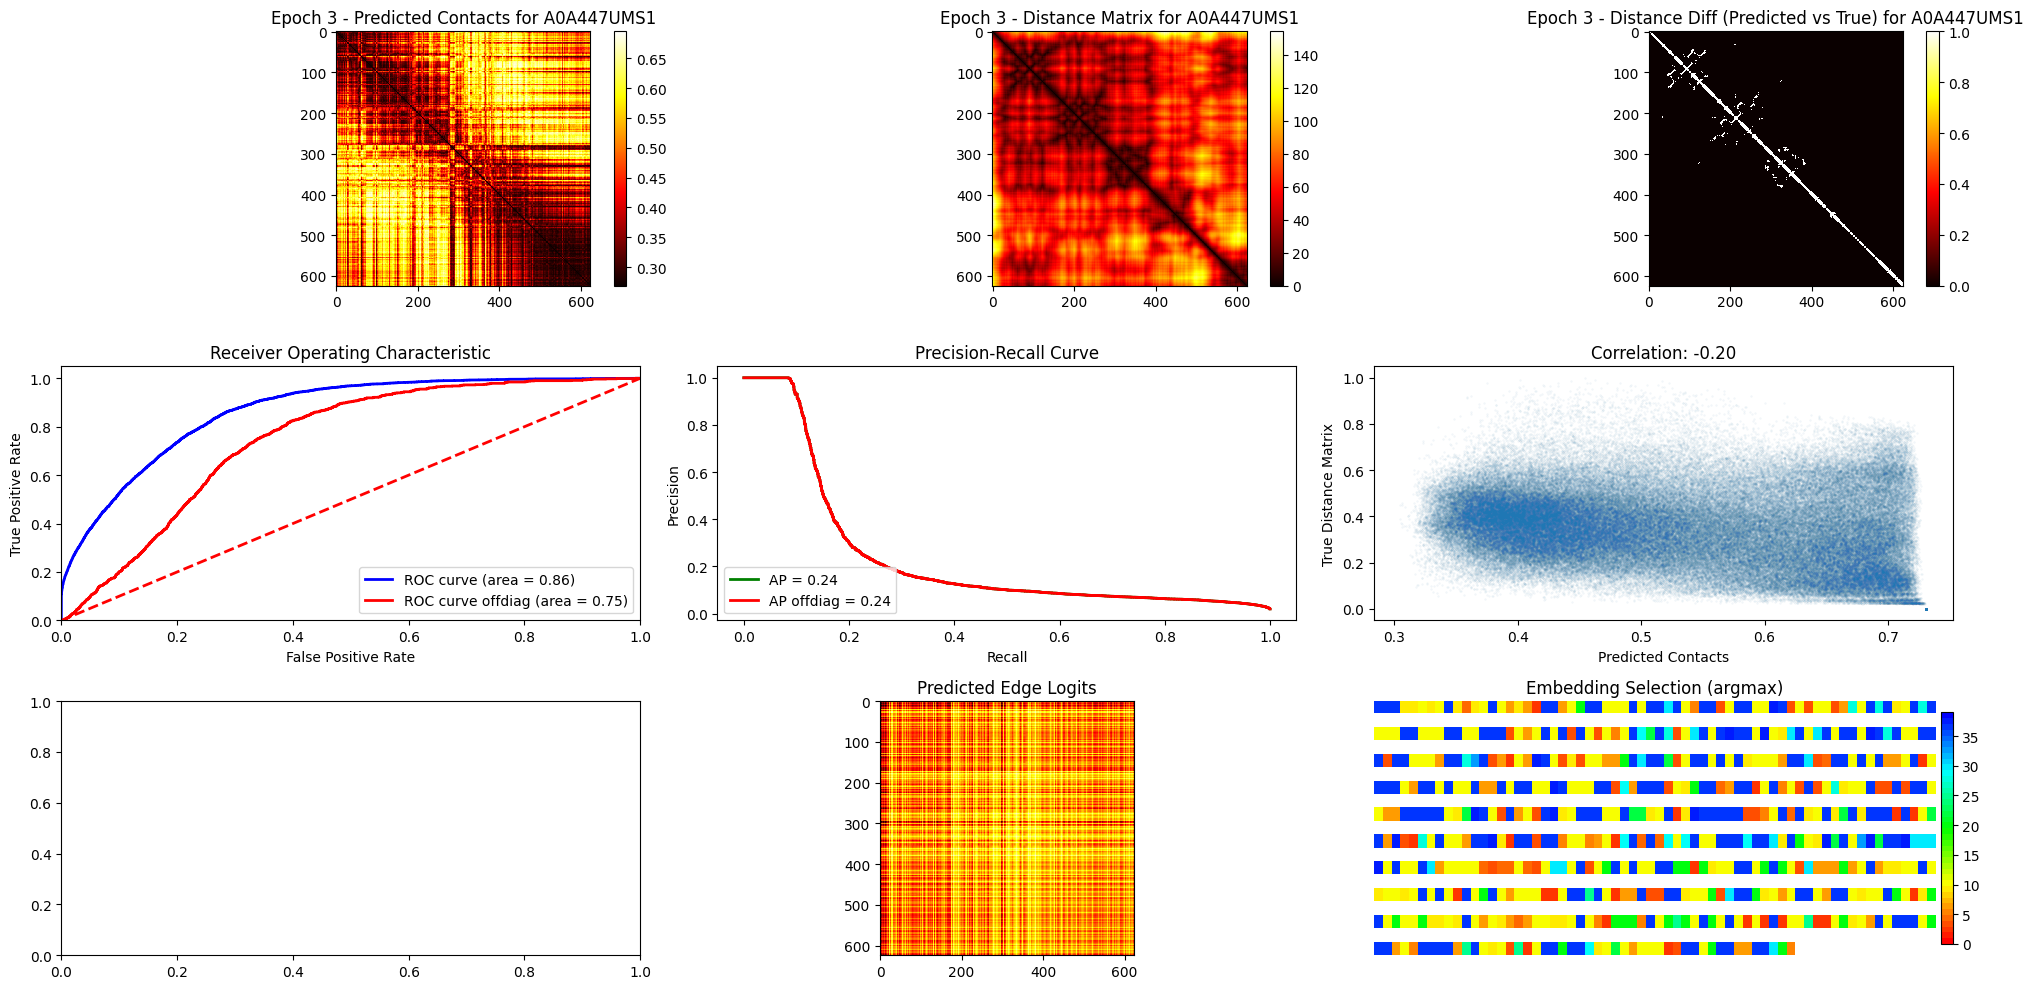

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:37<00:00,  2.22s/it]


Epoch 4: AA Loss: 1.1826, Edge Loss: 1.0463, VQ Loss: 0.3163 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.4748
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37,  3,  3,  8, 27, 19, 37,  3,  4,  3, 19, 37,  8,  9, 27, 27,
         2, 37, 37, 27,  6, 29, 37, 37,  9, 10, 10, 37, 39, 37, 37, 30, 37,  9,
        33, 37, 37, 29, 39, 37, 37, 39,  9, 28, 37, 38,  6, 38, 27,  6, 38,  3,
        33, 27, 37, 33, 37,  3,  6, 37, 33, 37, 39,  6, 27, 37, 37,  6,  6, 27,
        37, 37, 27, 39, 37, 37, 37, 38, 27,  3, 27, 37,  6, 37, 38, 37,  9, 38,
         9, 23,  6, 37,  4, 28, 37, 33, 38,  6,  2, 37,  6, 37, 28, 37, 32,  9,
        28, 27,  3, 30, 37, 27, 30, 32,  6, 37, 37, 27, 38, 37, 33, 37, 10,  9,
        37, 37, 37, 38, 37, 32, 39, 27,  6,  3, 37, 37,  5, 30, 37, 38,  3, 32,
         9,  3, 28, 37, 10, 28, 20, 38, 10,  9,  3,  3, 22, 37, 30, 37, 37,  5,
        29, 39, 37, 37, 39, 37, 39, 37,  3,  6,  9, 19, 27, 37, 37,  0, 2

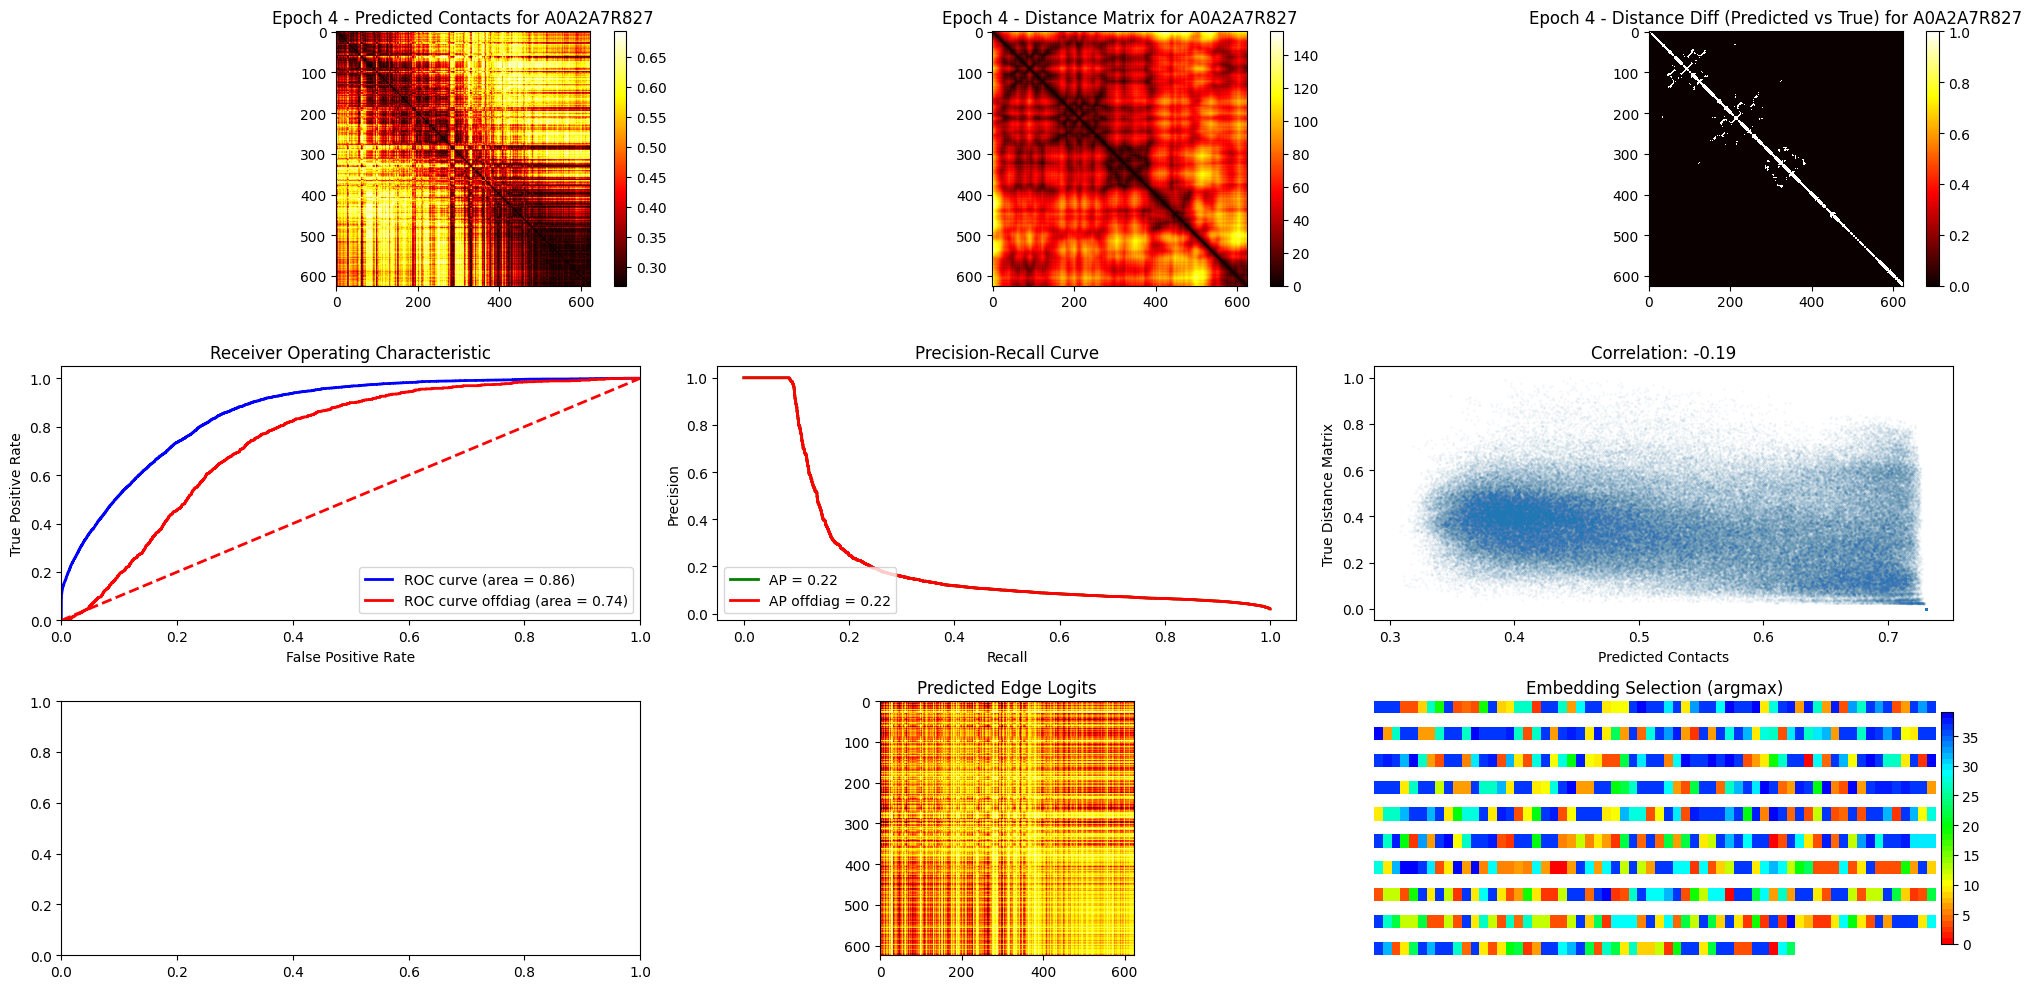

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:39<00:00,  2.24s/it]


Epoch 5: AA Loss: 0.9415, Edge Loss: 1.0487, VQ Loss: 0.2262 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.4158
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37, 27, 27, 12, 27, 18, 37, 20,  5, 20, 18, 37,  9, 27,  3,  3,
         2, 37, 37,  3,  6, 22, 37, 37, 27, 19, 19, 37, 18, 37, 37,  2, 37,  9,
        30, 37, 37, 22, 19, 37, 37, 18, 27, 28, 37, 22,  6, 22, 27, 39, 22, 20,
        23, 27, 37, 23, 37, 20,  6, 37, 23, 37, 18,  6, 27, 37, 37, 39, 39,  9,
        37, 37, 27, 18, 37, 37, 37, 22, 27, 20, 27, 37, 39, 37, 22, 37,  9, 22,
         9, 23, 12, 37,  4, 28, 37, 23, 38,  6,  2, 37, 39, 37,  5, 37, 32,  9,
        28, 27, 20,  2, 37, 27,  2, 32, 12, 37, 37,  3, 22, 37, 23, 37, 39,  9,
        37, 37, 37, 22, 37, 32, 18, 27, 39, 20, 37, 37, 33,  2, 37, 22, 20, 32,
         9, 20, 28, 37, 39, 28, 38, 38, 12, 27,  3, 20, 28, 37,  2, 37, 37, 23,
        38, 18, 37, 37, 39, 37, 39, 37, 20,  9, 27, 18,  3, 37, 37,  2, 2

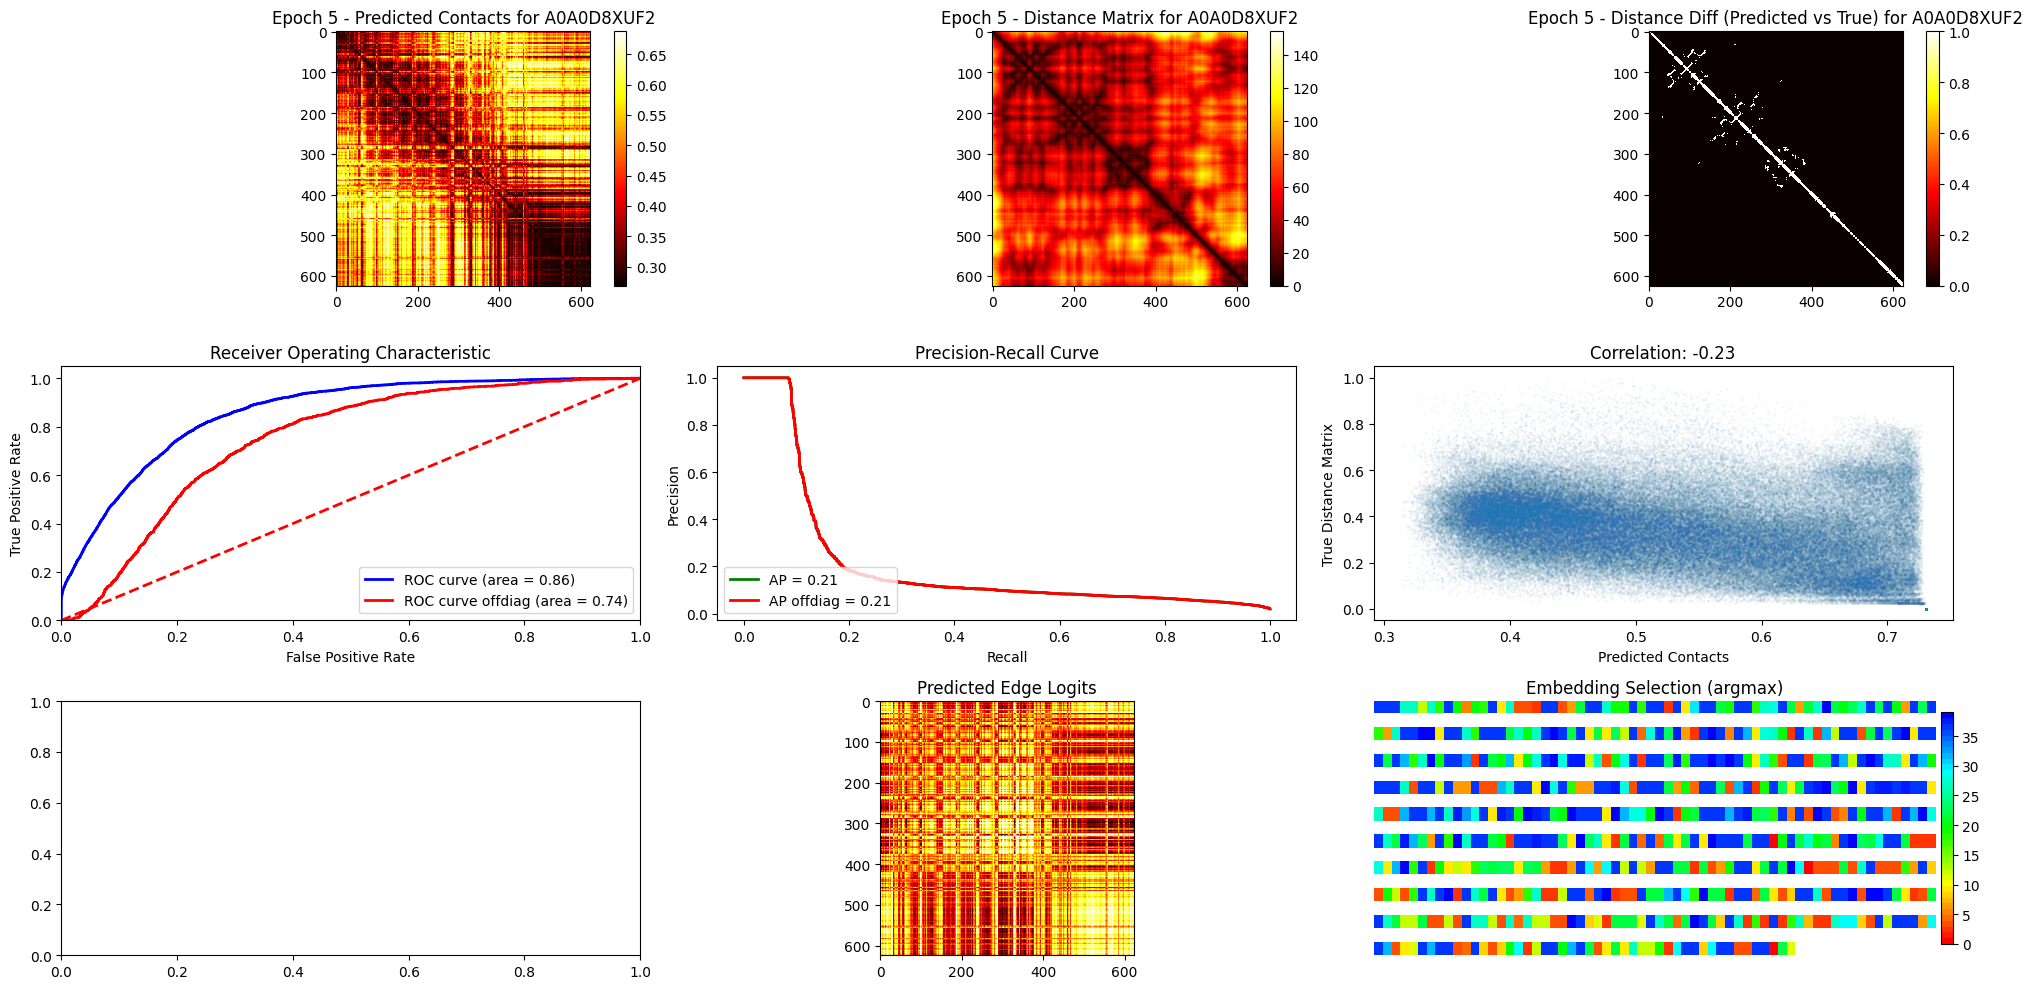

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:37<00:00,  2.22s/it]


Epoch 6: AA Loss: 0.7353, Edge Loss: 1.0491, VQ Loss: 0.1861 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.3321
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37,  3,  3, 36,  3,  1, 37, 29,  5, 29, 18, 37,  9, 27, 29,  3,
         2, 37, 37,  3,  9,  4, 37, 37, 27, 39, 39, 37, 18, 37, 37,  2, 37,  9,
        30, 37, 37, 22, 39, 37, 37, 18, 27,  5, 32, 28,  6,  4,  3, 39, 28, 20,
        23,  3, 37, 23, 37, 20,  6, 37, 23, 37, 18,  6,  3, 37, 37, 39, 39, 27,
        37, 37,  3, 18, 37, 37, 37, 28,  3, 20,  3, 37, 39, 37, 28, 37,  9, 28,
         9, 23,  6, 37,  5, 33, 37, 23, 38,  6,  2, 37, 39, 37, 33, 37, 32, 27,
        33,  3, 20,  2, 37, 27,  2, 32, 39, 37, 37,  3, 28, 37, 33, 37, 39,  9,
        37, 37, 37, 28, 37, 32, 18,  3, 39, 20, 37, 37, 33,  2, 37, 28, 20, 32,
         9, 20,  5, 37, 39,  5, 38, 28, 39, 27, 20, 20,  5, 37,  2, 37, 37, 33,
        22, 18, 37, 37, 19, 37, 39, 37, 29,  9, 27, 18,  3, 37, 37,  2, 2

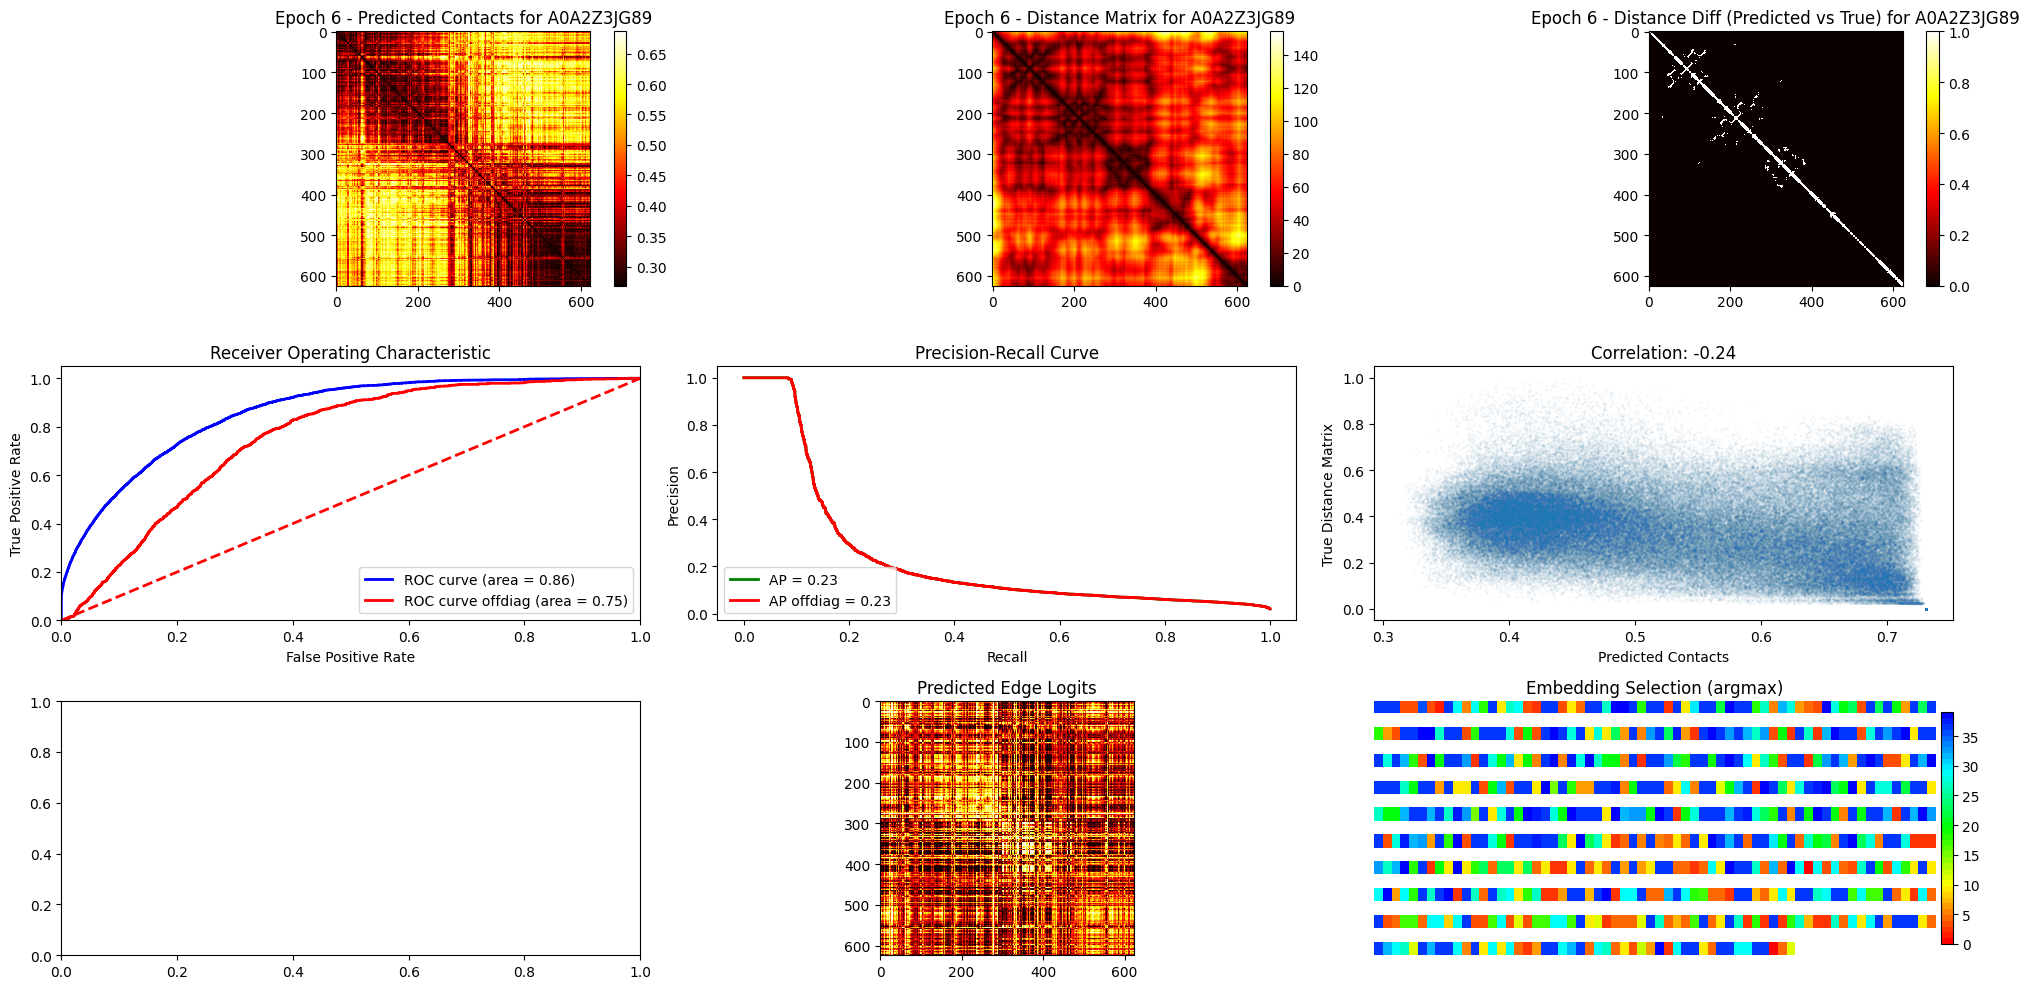

Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:38<00:00,  2.23s/it]


Epoch 7: AA Loss: 0.6200, Edge Loss: 1.0487, VQ Loss: 0.1893 , FFT2 Loss: 0.0000 , Angles Loss: 0.0000 , Logit Loss: 3.2607
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([37, 37, 37,  3,  3, 17,  3,  1, 37, 20,  7, 29, 18, 37,  9, 27, 29, 29,
         2, 37, 37, 29,  8,  4, 37, 37, 27, 19, 19, 37, 34, 37, 37,  2, 37,  9,
        30, 37, 37, 28, 19, 37, 37, 34, 27,  5, 37, 28,  6,  4,  3, 39, 28, 20,
        23,  3, 37, 23, 37, 20,  6, 37, 23, 37, 34,  6,  3, 37, 37, 39, 19,  9,
        37, 37,  3, 34, 37, 37, 37, 28,  3, 20,  3, 37, 39, 37, 28, 37,  9,  4,
         9, 11,  6, 37,  5,  5, 37, 23, 38,  6, 35, 37, 39, 37,  5, 37, 32,  9,
        15,  3, 20, 35, 37,  9, 35, 32, 19, 37, 37,  3, 28, 37, 23, 37, 39,  9,
        37, 37, 37, 28, 37, 37, 18,  3, 39, 20, 37, 37, 23, 35, 37, 28, 20, 32,
         9, 20, 15, 37, 19, 15, 38, 28, 39, 27,  3, 20, 15, 37,  2, 37, 37,  5,
        22, 34, 37, 37, 19, 37, 19, 37, 29,  9, 27, 18,  3, 37, 37,  2, 2

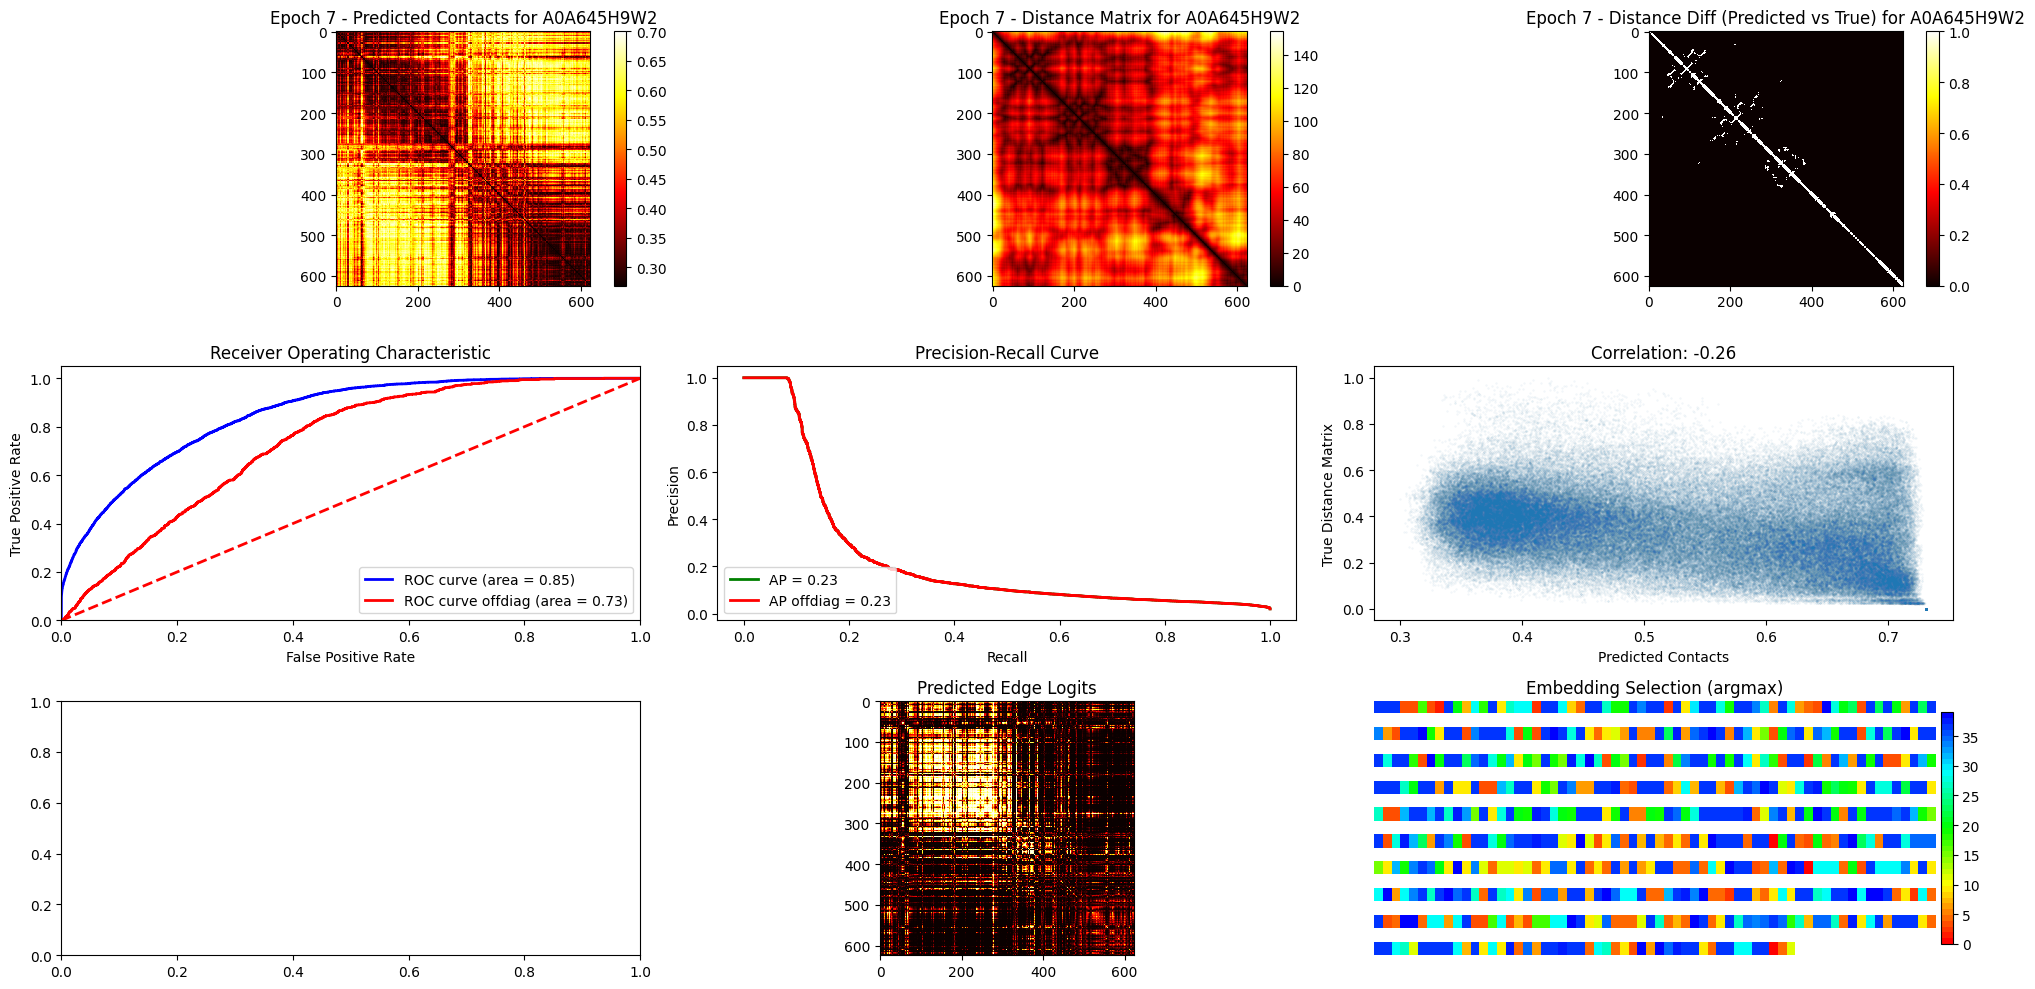

Epoch 8:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 77/125 [02:49<01:47,  2.23s/it]

In [ ]:
train_loader = DataLoader(struct_dat, batch_size=40, shuffle=True, num_workers=4)
encoder.train()
decoder.train()
hammingdistances = []
figurestack = []

reload = False
import glob
if reload == True:
	models = glob.glob('models/test_encoder_epoch_*.pkl')
	if len(models) > 0:
		latest_model = max(models, key=os.path.getctime)
		print(f"Loading model from {latest_model}")
		import pickle
		with open(latest_model, 'rb') as f:
			encoder = pickle.load(f)
		#load the corresponding decoder
		decoder_model = latest_model.replace('encoder', 'decoder')
		with open(decoder_model, 'rb') as f:
			decoder = pickle.load(f)
		encoder = encoder.to(device)
		decoder = decoder.to(device)
		encoder.train()
		decoder.train()

from foldtree2.src.losses.losses import recon_loss_diag , aa_reconstruction_loss
for epoch in range(num_epochs):
	total_loss_x = 0
	total_loss_edge = 0
	total_vq = 0
	total_angles_loss = 0
	total_loss_fft2 = 0
	total_logit_loss = 0
	for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
		data = data.to(device)
		optimizer.zero_grad()
		z, vqloss = encoder(data)
		data['res'].x = z
		# For demonstration, only sequence and contacts tasks
		out = decoder(data, None)
		recon_x = out['aa'] if isinstance(out, dict) and 'aa' in out else out[0] if isinstance(out, (list, tuple)) else None
		fft2_x = out['fft2pred'] if isinstance(out, dict) and 'fft2pred' in out else out[1] if isinstance(out, (list, tuple)) else None
		# Edge loss: use contactPoints if available
		edge_index = data.edge_index_dict['res', 'contactPoints', 'res'] if hasattr(data, 'edge_index_dict') and ('res', 'contactPoints', 'res') in data.edge_index_dict else None
		logitloss = torch.tensor(0.0, device=device)
		if edge_index is not None:
			edgeloss , logitloss = recon_loss_diag(data, edge_index, decoder, plddt=False, offdiag=False , key = 'edge_probs')
		else:
			edgeloss = torch.tensor(0.0, device=device)
		
		xloss = aa_reconstruction_loss(data['AA'].x, recon_x)
		if fft2_x is not None:
			fft2loss = F.smooth_l1_loss(torch.cat( [ data['fourier2dr'].x ,data['fourier2di'].x ] ,axis = 1 ) , fft2_x )
		else:
			fft2loss = torch.tensor(0.0, device=device)
		
		angles_loss = torch.tensor(0.0, device=device)
		if out['angles'] is not None:
			angles = out['angles']
			angles_loss = F.smooth_l1_loss(angles, data['bondangles'].x)

		loss = xweight * xloss + edgeweight * edgeloss + vqweight * vqloss + fft2loss* fft2weight + angles_loss * angles_weight + logitloss * logitweight

		loss.backward()
		if clip_grad:
			torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
			torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
		optimizer.step()
		total_loss_x += xloss.item()
		total_logit_loss += logitloss.item()
		total_loss_edge += edgeloss.item()
		total_loss_fft2 += fft2loss.item()
		total_angles_loss += angles_loss.item()
		total_vq += vqloss.item() if isinstance(vqloss, torch.Tensor) else float(vqloss)
	scheduler.step(total_loss_x)
	# save the model every 10 epochs
	if epoch % 10 == 0:
		torch.save(encoder.state_dict(), f'models/encoder_epoch_{epoch}.pt')
		torch.save(decoder.state_dict(), f'models/decoder_epoch_{epoch}.pt')
		#pickle the encoder and decoder
		import pickle
		with open(f'models/test_encoder_epoch_{epoch}.pkl', 'wb') as f:
			pickle.dump(encoder, f)
		with open(f'models/test_decoder_epoch_{epoch}.pkl', 'wb') as f:
			pickle.dump(decoder, f)

	print(f"Epoch {epoch}: AA Loss: {total_loss_x/len(train_loader):.4f}, Edge Loss: {total_loss_edge/len(train_loader):.4f}, VQ Loss: {total_vq/len(train_loader):.4f} , FFT2 Loss: {total_loss_fft2/len(train_loader):.4f} , Angles Loss: {total_angles_loss/len(train_loader):.4f} , Logit Loss: {total_logit_loss/len(train_loader):.4f}")

	encoder.eval()
	decoder.eval()
	
	# predict all vs all contacts for the last sample
	data_sample = data_sample.to(device)
	z, vqloss = encoder(data_sample)
	print('Encoded z shape:', z.shape)
	ords = encoder.vector_quantizer.discretize_z(z.detach())
	zdiscrete = ords[0].detach()
	print('Encoded zdiscrete shape:', zdiscrete.shape)
	aastr, edge_probs , logits ,sample_out = decoder_reconstruction2aa( zdiscrete , device, verbose=True)
	#show the distance matrix
	grab_struct(str(data_sample.identifier) , structfolder='tmp/')
	#find the total number of residues
	ca_atoms = getCAatoms( 'tmp/' + str(data_sample.identifier) + '.pdb')
	dist_mat = np.zeros((len(ca_atoms), len(ca_atoms)))
	
	for i, res1 in enumerate(ca_atoms):
		for j, res2 in enumerate(ca_atoms):
			if i < j:
				dist_mat[i, j] = np.linalg.norm(res1.coord - res2.coord)
	dist_mat += dist_mat.T  # Make it symmetric
	np.fill_diagonal(dist_mat, 0)
	
	ndistmat = dist_mat.copy()
	ndistmat[dist_mat>10 ] = 0
	ndistmat[dist_mat<=10 ] = 1

	fig, axs = plt.subplots(3, 3, figsize=(20, 10))

	# Predicted Contacts
	im0 = axs[0, 0].imshow( 1- edge_probs.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
	axs[0, 0].set_title(f"Epoch {epoch} - Predicted Contacts for {data.identifier[0]}")
	fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

	# Distance Matrix
	im1 = axs[0, 1].imshow(dist_mat, cmap='hot', interpolation='nearest')
	axs[0, 1].set_title(f"Epoch {epoch} - Distance Matrix for {data.identifier[0]}")
	fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

	# Distance Diff
	im2 = axs[0, 2].imshow( ndistmat , cmap='hot', interpolation='nearest')
	axs[0, 2].set_title(f"Epoch {epoch} - Distance Diff (Predicted vs True) for {data.identifier[0]}")
	fig.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

	# exclude diagonal from the distance matrix in the ROC and Precision-Recall curves
	npdistmat = ndistmat.copy()
	edge_probs = edge_probs.detach().cpu().numpy()
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	#flatten both matrices for ROC and Precision-Recall curves
	ndistmat_flat = npdistmat.flatten()
	edge_probs_flat = edge_probs.flatten()
	# Remove NaN values from both arrays
	
	# ROC Curve
	fpr, tpr, _ = roc_curve(ndistmat_flat, edge_probs_flat)
	roc_auc = auc(fpr, tpr)
	axs[1, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
	axs[1, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
	axs[1, 0].set_xlim([0.0, 1.0])
	axs[1, 0].set_ylim([0.0, 1.05])

	# Precision-Recall Curve
	y_true = ndistmat_flat
	y_scores = edge_probs_flat
	precision, recall, _ = precision_recall_curve(y_true, y_scores)
	ap_score = average_precision_score(y_true, y_scores)
	axs[1, 1].plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.2f}')
	
	# Mask out entries not separated by at least 10 residues
	mask = np.fromfunction(lambda i, j: np.abs(i - j) >= 10, dist_mat.shape)
	masked_ndistmat = np.where(mask, ndistmat, np.nan)
	masked_edge_probs = np.where(mask, edge_probs, np.nan)

	# Flatten and filter out nan values
	ndistmat_flat_masked = masked_ndistmat.flatten()
	edge_probs_flat_masked = masked_edge_probs.flatten()
	valid_mask = ~np.isnan(ndistmat_flat_masked) & ~np.isnan(edge_probs_flat_masked)
	ndistmat_flat_masked = ndistmat_flat_masked[valid_mask]
	edge_probs_flat_masked = edge_probs_flat_masked[valid_mask]

	y_true = ndistmat_flat
	y_scores = edge_probs_flat
	# ROC Curve for off-diagonal only
	fpr, tpr, _ = roc_curve(ndistmat_flat_masked, edge_probs_flat_masked)
	roc_auc = auc(fpr, tpr)
	axs[1, 0].plot(fpr, tpr, color='red', lw=2, label=f'ROC curve offdiag (area = {roc_auc:.2f})')
	
	axs[1, 0].set_xlabel('False Positive Rate')
	axs[1, 0].set_ylabel('True Positive Rate')
	axs[1, 0].set_title('Receiver Operating Characteristic')
	axs[1, 0].legend(loc='lower right')

	axs[1, 1].set_xlabel('Recall')
	axs[1, 1].set_ylabel('Precision')
	axs[1, 1].set_title('Precision-Recall Curve')
	axs[1, 1].legend(loc='lower left')

	dist_mat_flat = dist_mat.flatten()  # Ensure we use the same valid mask for distance matrix
	dist_mat_flat = dist_mat_flat/dist_mat_flat.max()  # Normalize the distance matrix for better visualization
	# Correlation
	corr = np.corrcoef( y_scores, dist_mat_flat)[0, 1]
	axs[1, 2].scatter( y_scores, dist_mat_flat, alpha=0.05 , s=.1  )
	axs[1, 2].set_xlabel('Predicted Contacts')
	axs[1, 2].set_ylabel('True Distance Matrix')
	axs[1, 2].set_title(f'Correlation: {corr:.2f}')


	if 'angles' in sample_out and sample_out['angles'] is not None:
		true_angles = data_sample['bondangles'].x.detach().cpu().numpy()
		pred_angles = sample_out['angles'].detach().cpu().numpy()
		angle_names = ['N-Ca-C', 'Ca-C-N', 'C-N-Ca']
		angle_colors = ['r', 'g', 'b']
		#plot the angles
		for i in range(3):
			axs[2,0].plot(true_angles[:,i], label='True ' + angle_names[i], color=angle_colors[i] , alpha = 0.5)
			axs[2,0].plot(pred_angles[:,i], label='Predicted ' + angle_names[i], color=angle_colors[i], linestyle='--'  , alpha = 0.5)		
		axs[2,0].legend()
		axs[2,0].set_title('Bond Angles')
	
	axs[2,1].imshow( logits.detach().cpu().numpy(), cmap='hot', interpolation='nearest' )
	axs[2,1].set_xlabel('Residue Index')
	axs[2,1].set_ylabel('Residue Index')
	#colorbar
	fig.colorbar(im0, ax=axs[2,1], fraction=0.046, pad=0.04)
	axs[2,1].set_title('Predicted Edge Logits')

	#show foldtree2 sequence on the last subplot
	plot_logits_sequence_on_ax( zdiscrete.detach().cpu().numpy() , num_embeddings , axs[2,2] , max_width=64 , show_colorbar=True)

	figurestack.append(fig)
	plt.tight_layout()
	plt.show()
	encoder.train()
	decoder.train()

	#save model checkpoint
	if epoch % 20 == 0:
		torch.save(encoder, f'models/encoder_epoch_{epoch}.pt')
		torch.save(decoder, f'models/decoder_epoch_{epoch}.pt')

